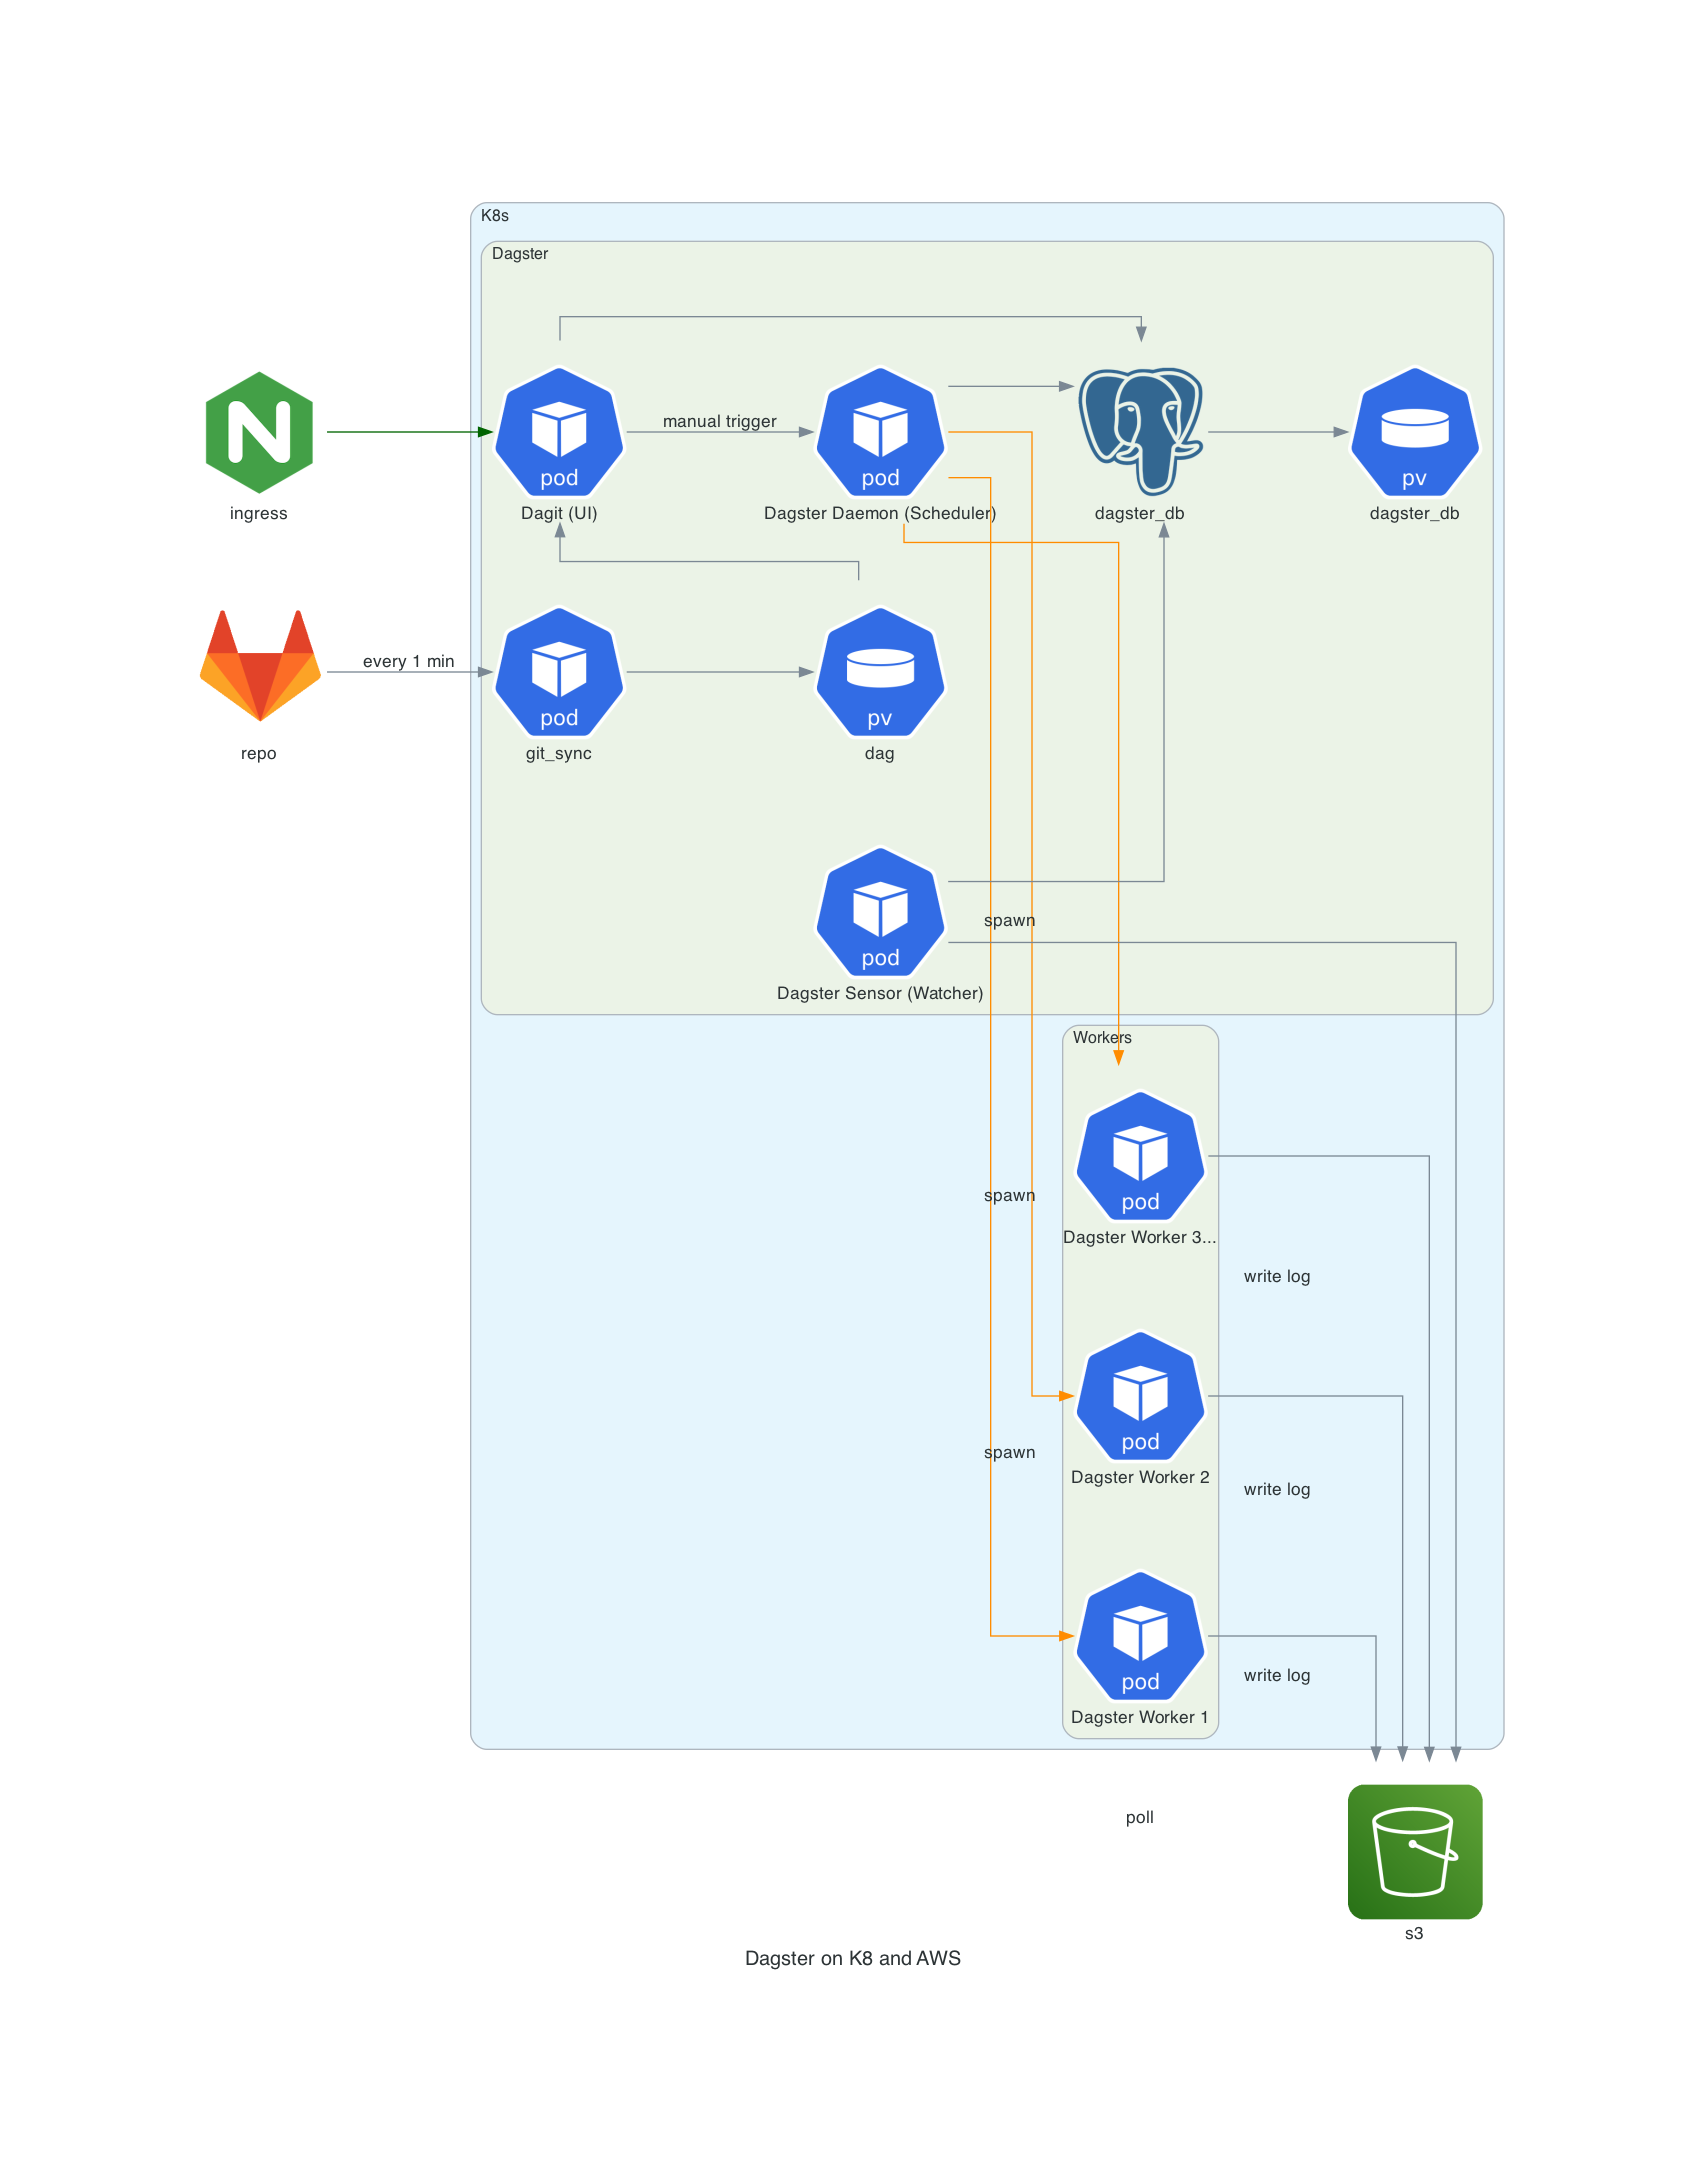

In [48]:
from diagrams import Cluster, Diagram, Edge
from diagrams.onprem.analytics import Spark
from diagrams.onprem.database import PostgreSQL
from diagrams.onprem.network import Nginx
from diagrams.onprem.queue import Kafka
from diagrams.onprem.vcs import Gitlab
from diagrams.k8s.compute import Pod, Deploy
from diagrams.k8s.storage import PV
from diagrams.aws.storage import S3

with Diagram(name="Dagster on K8 and AWS", show=False) as diag:
    ingress = Nginx("ingress")
    gitlab = Gitlab("repo")
    s3 = S3("s3")

    with Cluster("K8s"):
        with Cluster("Dagster"):
            git_sync = Pod("git_sync")
            dagit = Pod("Dagit (UI)")
            daemon = Pod("Dagster Daemon (Scheduler)")
            sensor = Pod("Dagster Sensor (Watcher)")
            
            dag_pv = PV("dag")
            
            dagster_db = PostgreSQL("dagster_db")
            dagster_db_pv = PV("dagster_db")
            
            grpcsvc = [
                dagit,
                daemon,
                sensor,
                db,
            ]
            
            dagster_db >> dagster_db_pv
            git_sync >> dag_pv 
            dagit << dag_pv
            daemon >> dagster_db
            dagit >> dagster_db
            sensor >> dagster_db
            
        with Cluster("Workers"):
            workers = [
                Pod("Dagster Worker 1"),
                Pod("Dagster Worker 2"),
                Pod("Dagster Worker 3...")
            ]
            
    gitlab >> Edge(label="every 1 min") >> git_sync

    ingress >> Edge(color="darkgreen") >> dagit
    daemon >> Edge(label="spawn", color="darkorange") >> workers
    workers >> Edge(label="write log") >> s3
    sensor >> Edge(label="poll") >> s3
    dagit >> Edge(label="manual trigger") >> daemon
    
diag